In [1]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
import os
import shutil
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

In [3]:
root_dir = '/kaggle/input/welding-defect-object-detection'
v1_dir = os.path.join(root_dir, 'The Welding Defect Dataset/The Welding Defect Dataset')
v2_dir = os.path.join(root_dir, 'The Welding Defect Dataset - v2/The Welding Defect Dataset - v2')

Покажем несколько фото для примера.

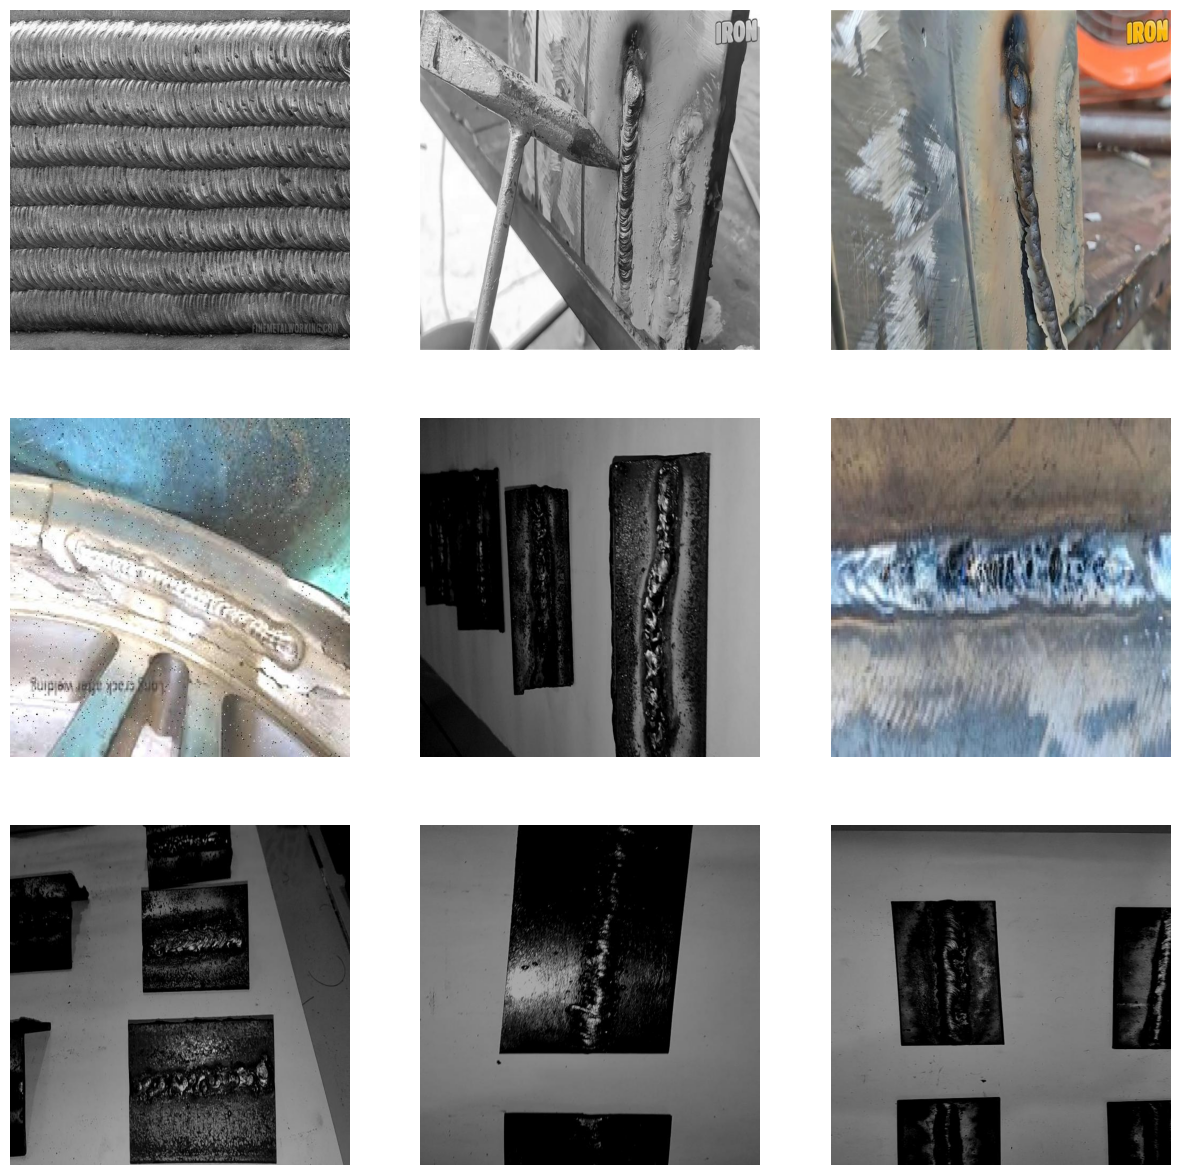

In [4]:
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = images[:num_images]
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img_rgb = Image.open(image_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

display_images(os.path.join(v1_dir, 'train/images'))


Прочитаем лейблы и посмотрим на соотношение классов.

In [5]:
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
v2_train_labels = load_labels(os.path.join(v2_dir, 'train/labels'))

Text(0.5, 1.0, 'class_id in training dataset version 2')

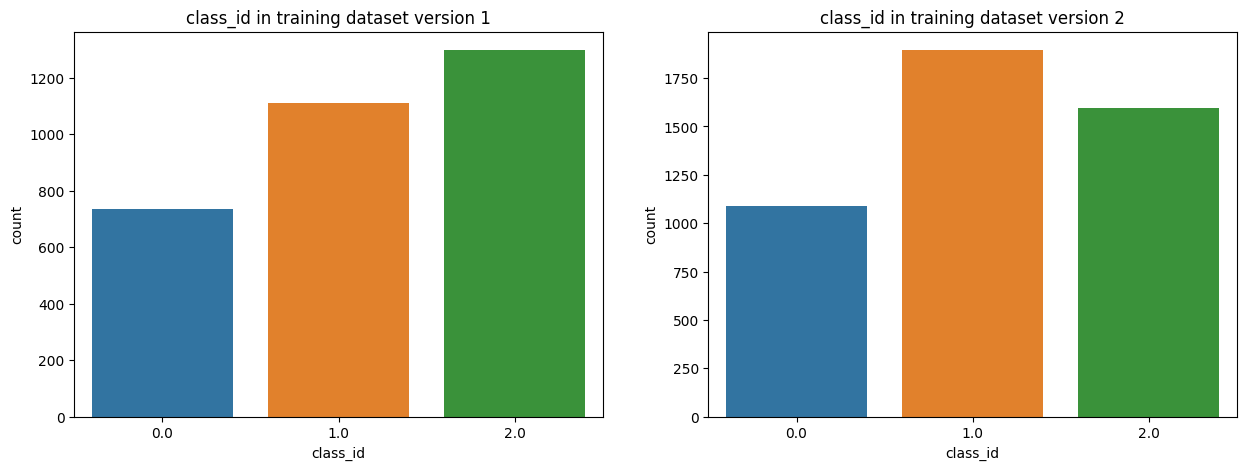

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axe = axs.ravel()

sns.countplot(data=v1_train_labels, x='class_id', ax=axe[0])

axs[0].set_title("class_id in training dataset version 1")
sns.countplot(data=v2_train_labels, x='class_id', ax=axe[1])

axs[1].set_title("class_id in training dataset version 2")

Копируем датасет и укажем полный путь до изображений для модели в файле yaml.

In [7]:
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

copy_dataset_to_yolo(v1_dir, 'data/welding_v1')

copy_dataset_to_yolo(v2_dir, 'data/welding_v2')

In [8]:
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

update_data_yaml('/kaggle/working/data/welding_v1/data.yaml', '/kaggle/working/data/welding_v1')

update_data_yaml('/kaggle/working/data/welding_v2/data.yaml', '/kaggle/working/data/welding_v2')

def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('/kaggle/working/data/welding_v1/data.yaml')

print("Updated data.yaml for version 2:")
print_data_yaml('/kaggle/working/data/welding_v2/data.yaml')

Updated data.yaml for version 1:
train: /kaggle/working/data/welding_v1/train/images
val: /kaggle/working/data/welding_v1/valid/images
test: /kaggle/working/data/welding_v1/test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']


Updated data.yaml for version 2:
train: /kaggle/working/data/welding_v2/train/images
val: /kaggle/working/data/welding_v2/valid/images
test: /kaggle/working/data/welding_v2/test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']




Возьмем среднюю модель yolo 8. По сравнению с дефолтными параметрами уменьшим box и iou, а cls и dfl увеличим. Кажется, что в этой задаче определение класса важнее точной рамки, и изменение таких параметров должно это учесть. Увеличим mixup, чтобы добавить шум.

In [9]:
model_v1 = YOLO('yolov8m.pt')

results_train = model_v1.train(data='/kaggle/working/data/welding_v1/data.yaml', epochs=200, name='welding_v1_train', 
               lr0=0.01, weight_decay=0.0005, warmup_epochs=3.0, box=0.1, cls=1, dfl=3, iou=0.3, mixup=0.5, plots=True)

100%|██████████| 49.7M/49.7M [00:00<00:00, 239MB/s]


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.1, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data/welding_v1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=3, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.3, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.5, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=welding_v1_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1247.9±601.3 MB/s, size: 50.2 KB)


train: Scanning /kaggle/working/data/welding_v1/train/labels... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:00<00:00, 1365.67it/s]

train: New cache created: /kaggle/working/data/welding_v1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 944.7±666.5 MB/s, size: 55.6 KB)


val: Scanning /kaggle/working/data/welding_v1/valid/labels... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 1232.25it/s]

val: New cache created: /kaggle/working/data/welding_v1/valid/labels.cache


Plotting labels to runs/detect/welding_v1_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/welding_v1_train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      6.19G    0.02888      5.534       3.69         57        640: 100%|██████████| 53/53 [00:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all        176        573      0.417      0.296     0.0827     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      7.35G    0.02828      4.872      3.642         74        640: 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.186      0.216      0.128     0.0454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      7.35G    0.02866      4.899      3.759         51        640: 100%|██████████| 53/53 [00:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        176        573      0.366      0.212      0.177     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      7.36G    0.02818      4.759      3.668         74        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

                   all        176        573      0.125      0.154     0.0815     0.0269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      7.36G    0.02745      4.601       3.69         61        640: 100%|██████████| 53/53 [00:30<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        176        573      0.217      0.391      0.194     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      7.36G    0.02694      4.595      3.569         82        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        176        573      0.287      0.377      0.248      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      7.36G    0.02682      4.504      3.581         69        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        176        573      0.367      0.427      0.333      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      7.36G    0.02602      4.345      3.523         39        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.352      0.433      0.348      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      7.36G    0.02558      4.282      3.464         49        640: 100%|██████████| 53/53 [00:28<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        176        573      0.329      0.456      0.323      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      7.36G    0.02531      4.184      3.401         80        640: 100%|██████████| 53/53 [00:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        176        573      0.411      0.442      0.377      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      7.36G    0.02487      4.127      3.368         27        640: 100%|██████████| 53/53 [00:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        176        573      0.326      0.523       0.35      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      7.36G    0.02536      4.201      3.427         55        640: 100%|██████████| 53/53 [00:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.361        0.5      0.369      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      7.36G    0.02459      4.014      3.344         99        640: 100%|██████████| 53/53 [00:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        176        573      0.435      0.448      0.383      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      7.36G    0.02446      3.962      3.298         71        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        176        573      0.357      0.486      0.356      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      7.36G    0.02439      3.903      3.276         49        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        176        573      0.398      0.533      0.406      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      7.36G    0.02397      3.879      3.287         64        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        176        573      0.379      0.524      0.398      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      7.36G    0.02417      3.904       3.31         41        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.419       0.48      0.382      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      7.36G    0.02365      3.839      3.225        104        640: 100%|██████████| 53/53 [00:27<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.456      0.504      0.438      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      7.36G    0.02361      3.808      3.205         98        640: 100%|██████████| 53/53 [00:27<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        176        573      0.399      0.569      0.415      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      7.36G     0.0237      3.731      3.266         46        640: 100%|██████████| 53/53 [00:27<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.476      0.519       0.43      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      7.36G    0.02345      3.713      3.199         83        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.455      0.485      0.418      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      7.36G    0.02299      3.586       3.15         44        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        176        573      0.455      0.564      0.466      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      7.36G    0.02331      3.727      3.218         30        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        176        573       0.46      0.497      0.433      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      7.36G    0.02332      3.631      3.194         77        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.446      0.507      0.441      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      7.36G    0.02281      3.544      3.125         44        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.467      0.576      0.451      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      7.36G    0.02251      3.509      3.103         65        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        176        573      0.454      0.548      0.457      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      7.36G    0.02232      3.431      3.056         67        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.495       0.56      0.485      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      7.36G    0.02221      3.401      3.067         58        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        176        573      0.449      0.577      0.468      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      7.36G    0.02243      3.441      3.099         70        640: 100%|██████████| 53/53 [00:29<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        176        573      0.452      0.543      0.461      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      7.36G    0.02205      3.386      3.047         72        640: 100%|██████████| 53/53 [00:30<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        176        573      0.519      0.549      0.492      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      7.36G    0.02235      3.433      3.097         81        640: 100%|██████████| 53/53 [00:29<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.448      0.532      0.418      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      7.36G    0.02185       3.28      3.059         66        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        176        573      0.521      0.572      0.516       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      7.36G    0.02201      3.321      3.024         53        640: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        176        573      0.481      0.574      0.456      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      7.36G    0.02202      3.276      3.057         44        640: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        176        573      0.544      0.566      0.521      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      7.36G    0.02147        3.2      2.984         73        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.565       0.61      0.555      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      7.36G    0.02118      3.107      2.956         43        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.495      0.579      0.495      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      7.36G     0.0212      3.101      2.941         83        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573      0.524       0.54      0.508      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      7.36G     0.0213       3.11      2.976         64        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.512      0.573       0.49      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      7.36G    0.02155      3.183      3.018         39        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.545      0.511      0.495      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      7.36G    0.02098      3.038      2.931         88        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573       0.48       0.53      0.476      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      7.36G     0.0211      3.023      2.948         63        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        176        573      0.537      0.551      0.488      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      7.36G    0.02082      2.992       2.93         68        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.535      0.564      0.526      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      7.36G    0.02083       3.02      2.936         87        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.547      0.594      0.543      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      7.36G    0.02102      3.014      2.954         97        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.557      0.563      0.529      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      7.36G    0.02094      2.997      2.942         38        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573       0.56      0.593      0.545      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      7.36G    0.02062      2.971      2.922         48        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.535      0.542      0.493      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      7.36G     0.0206      2.942      2.928         50        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.512      0.571      0.506       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      7.36G    0.02042      2.908      2.913         51        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.591      0.609       0.58      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      7.36G    0.02005      2.881      2.869         58        640: 100%|██████████| 53/53 [00:29<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        176        573      0.584      0.585      0.561      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      7.36G    0.02012      2.819      2.869         46        640: 100%|██████████| 53/53 [00:28<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        176        573      0.555      0.558      0.504      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      7.36G    0.02045      2.847      2.907         59        640: 100%|██████████| 53/53 [00:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.599      0.502      0.516      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      7.36G    0.02036      2.799      2.866         48        640: 100%|██████████| 53/53 [00:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        176        573      0.543      0.534      0.525      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      7.36G    0.02007      2.819      2.868         72        640: 100%|██████████| 53/53 [00:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573       0.53      0.547      0.495       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      7.36G       0.02      2.804      2.848         46        640: 100%|██████████| 53/53 [00:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.591      0.563      0.556      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      7.36G    0.02002      2.748      2.848         41        640: 100%|██████████| 53/53 [00:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        176        573      0.617      0.599      0.594      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      7.36G     0.0199      2.722      2.832         68        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.509       0.58      0.529      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      7.36G    0.01969      2.694      2.819         66        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        176        573      0.539      0.585      0.506      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      7.36G    0.01978      2.724      2.831         49        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.587      0.586      0.574      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      7.36G    0.01958      2.657      2.804         64        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.618      0.577      0.571      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      7.36G    0.01963       2.67       2.82         65        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.561      0.584      0.532      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      7.36G    0.01924      2.644      2.791         65        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        176        573      0.591      0.567      0.537      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      7.36G    0.01917      2.599      2.763         30        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.569      0.589       0.58      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      7.36G    0.01931      2.584      2.771         44        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        176        573      0.521       0.58      0.522      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      7.36G      0.019      2.505       2.72         59        640: 100%|██████████| 53/53 [00:28<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        176        573       0.62      0.592      0.605      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      7.36G    0.01902      2.544      2.759         51        640: 100%|██████████| 53/53 [00:28<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        176        573       0.56      0.601      0.569      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      7.36G    0.01927       2.57       2.78        138        640: 100%|██████████| 53/53 [00:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.597      0.603      0.576      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      7.36G    0.01935      2.543      2.759         51        640: 100%|██████████| 53/53 [00:30<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573       0.56      0.567      0.542      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      7.36G    0.01913      2.566      2.759         62        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.632      0.607      0.597      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      7.36G    0.01871      2.426      2.697         93        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        176        573        0.6      0.613      0.588      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      7.36G    0.01902      2.525      2.776         75        640: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        176        573      0.612      0.523      0.555      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      7.36G    0.01902      2.523      2.773         87        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573      0.584      0.593      0.572      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      7.36G     0.0185      2.436      2.688         51        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.563      0.592      0.566      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      7.36G    0.01866      2.441      2.704         80        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573      0.545       0.62      0.553      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      7.36G    0.01856      2.382      2.704         88        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.585      0.601      0.589      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      7.36G    0.01915      2.495      2.777         54        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.648      0.555      0.581      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      7.36G     0.0184        2.4      2.703         56        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        176        573      0.609      0.559      0.583      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      7.36G    0.01835      2.368      2.676         84        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.607      0.603      0.586      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      7.36G     0.0185      2.402      2.686         77        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.625      0.616      0.602       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      7.36G    0.01854       2.41      2.703         49        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.639      0.577      0.577      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      7.36G    0.01844       2.35      2.681         50        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573       0.58      0.681      0.631      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      7.36G    0.01826      2.392       2.69         72        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573       0.61      0.587      0.589      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      7.36G    0.01824      2.335      2.661         73        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573      0.622      0.606      0.598      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      7.36G    0.01811      2.338      2.689         52        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.586      0.668      0.622      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      7.36G    0.01799      2.264      2.623         47        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.588      0.606      0.588      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      7.36G    0.01819      2.325      2.661         49        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.665      0.567      0.608      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      7.36G    0.01782      2.267      2.634         60        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573       0.57      0.625      0.584      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      7.36G    0.01801      2.305      2.663         34        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.634      0.607      0.602       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      7.36G    0.01763      2.272        2.6         48        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.641      0.601      0.622      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      7.36G    0.01805      2.316      2.686         48        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.631      0.606      0.603      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      7.36G    0.01828       2.36      2.671         71        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573        0.6      0.595      0.585      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      7.36G    0.01793      2.296      2.641         66        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.585      0.645      0.602      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      7.36G    0.01773       2.26      2.625         95        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        176        573      0.593      0.637      0.599      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      7.36G    0.01755      2.228      2.606         52        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.595      0.636      0.607      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      7.36G     0.0176      2.226      2.628         62        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.602      0.608       0.61      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      7.36G    0.01768      2.199      2.614         59        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.587      0.642      0.609      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      7.36G    0.01779      2.192      2.643         81        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.567       0.61      0.594      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      7.36G    0.01753      2.168      2.632         80        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.623      0.583      0.601       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      7.36G    0.01747      2.158      2.599         46        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.624      0.605      0.611      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      7.36G    0.01753      2.175      2.587         54        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573       0.62      0.598      0.606      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      7.36G    0.01711      2.094      2.555         63        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.615      0.617      0.612      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      7.36G    0.01753      2.182      2.595         65        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.603      0.603      0.615      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      7.36G    0.01723       2.16      2.603         64        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.642      0.598      0.614      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      7.36G    0.01684      2.053      2.544         49        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573       0.64      0.605      0.621      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      7.36G    0.01725      2.091       2.61         56        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.621      0.608       0.59      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      7.36G    0.01706      2.078      2.559         93        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.593      0.624      0.598      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      7.36G     0.0172      2.124      2.551         46        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.665      0.568      0.613      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      7.36G    0.01706      2.097      2.549         72        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.654      0.606      0.606      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      7.36G    0.01694      2.032      2.547         42        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.631      0.645       0.61      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      7.36G    0.01662      1.994      2.511         70        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573       0.61      0.596      0.602      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      7.36G    0.01688       2.06       2.54         35        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.594      0.638      0.621      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      7.36G    0.01693       2.05      2.555         44        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.663      0.585      0.619      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      7.36G    0.01673      1.985      2.517         70        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.646      0.629      0.629      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      7.36G     0.0166      2.027      2.523         66        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.676       0.58      0.628      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      7.36G    0.01669      2.015      2.523         54        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.655      0.612      0.621      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      7.36G    0.01645      1.983      2.492         64        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.678      0.617       0.64       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      7.36G    0.01626      1.907       2.47         54        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.669      0.619      0.641      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      7.36G    0.01626      1.954      2.487         69        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.702      0.573      0.625      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      7.36G    0.01622      1.943      2.477         70        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.633      0.635      0.636      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      7.36G    0.01642      1.946      2.489         60        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.672      0.595      0.619      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      7.36G     0.0165      1.972      2.518         63        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.661      0.645      0.645      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      7.36G    0.01636      1.942      2.478         56        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.682      0.598      0.636      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      7.36G    0.01622      1.942      2.465         62        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.677      0.618      0.635      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      7.36G    0.01617      1.905      2.484         72        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.678       0.61      0.626      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      7.36G    0.01638      1.927      2.478        104        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.644      0.629      0.626      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      7.36G    0.01639      1.936      2.492         79        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.667      0.597      0.597      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      7.36G    0.01627      1.937       2.49         43        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.639      0.666      0.645      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      7.36G    0.01615      1.934        2.5         46        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.668       0.65      0.641      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      7.36G    0.01583      1.855      2.454         77        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.664      0.623      0.635       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      7.36G    0.01585      1.864      2.465         59        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.661      0.625      0.625      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      7.36G    0.01578      1.822      2.433         90        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.622      0.646      0.621      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      7.36G    0.01612      1.875      2.459         78        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.661      0.577      0.613      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      7.36G    0.01557      1.838      2.406         67        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        176        573      0.605      0.684      0.637      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      7.36G    0.01582      1.841      2.435         97        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.665      0.628      0.634      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      7.36G    0.01598      1.875      2.451         62        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.635      0.665       0.64      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      7.36G    0.01575      1.867      2.453         62        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.683      0.614      0.626      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      7.36G    0.01598      1.871      2.484         51        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.669      0.652      0.649      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      7.36G    0.01575       1.82      2.431         50        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.658      0.633      0.646      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      7.36G    0.01546      1.801      2.403         60        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.656      0.646      0.653      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      7.36G    0.01571      1.838      2.412         85        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.651      0.615      0.621      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      7.36G    0.01549      1.812      2.418         27        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573       0.64      0.659      0.637      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      7.36G    0.01547      1.775      2.423         72        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.657       0.67      0.665      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      7.36G    0.01553      1.785      2.427         46        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573       0.63      0.659       0.63      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      7.36G    0.01538      1.786      2.425         47        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.665      0.643       0.66      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      7.36G    0.01524      1.767      2.403         36        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.674      0.632      0.652      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      7.36G    0.01539      1.775      2.393         64        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.681      0.633      0.655      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      7.36G    0.01549      1.782      2.409         33        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.704      0.638      0.669      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      7.36G    0.01517      1.761      2.381         61        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.692      0.638      0.657      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      7.36G    0.01526      1.758      2.383         52        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.669      0.642      0.651      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      7.36G    0.01516      1.756      2.381         73        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.646      0.642      0.642      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      7.36G    0.01547      1.797       2.41         52        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.689      0.639      0.645       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      7.36G    0.01504      1.733       2.37         52        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.682      0.646      0.644      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      7.36G    0.01496      1.727      2.394         53        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.643      0.651      0.637       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      7.36G    0.01513      1.717      2.394         61        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.694      0.605      0.639      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      7.36G    0.01503      1.744      2.376         67        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573       0.67      0.622      0.639       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      7.36G    0.01488      1.698      2.364         52        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.706      0.613      0.653      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      7.36G    0.01468      1.676      2.351         59        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.652      0.624      0.623      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      7.36G    0.01477      1.681      2.348         47        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.677      0.607      0.636      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      7.36G    0.01455      1.654      2.324         72        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573        0.7      0.621      0.663      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      7.36G    0.01495      1.697      2.363         62        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.651      0.632      0.651      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      7.36G    0.01477      1.669      2.357         67        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.665      0.636      0.643      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      7.36G    0.01452      1.638      2.349         80        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.694      0.654      0.656      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      7.36G    0.01476      1.672      2.342         39        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573       0.67       0.64      0.634      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      7.36G    0.01439      1.635      2.328         90        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.688      0.633      0.651      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      7.36G    0.01463      1.644      2.315         45        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.654      0.651      0.629      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      7.36G    0.01453      1.626      2.324         61        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573       0.69      0.638      0.639      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      7.36G    0.01456      1.643      2.328         79        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.684      0.609      0.632      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      7.36G    0.01434      1.601      2.291         61        640: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.679      0.601      0.626       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      7.36G    0.01441      1.612      2.317        103        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573       0.65      0.641      0.631      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      7.36G     0.0143      1.593      2.311         49        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.689      0.622      0.646      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      7.36G    0.01447      1.643      2.321         74        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        176        573      0.628      0.673      0.642      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      7.36G    0.01441       1.62       2.35         69        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.661      0.672      0.656      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      7.36G    0.01423      1.565      2.274         47        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.658      0.657      0.635      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      7.36G    0.01415      1.574      2.292         44        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.659      0.661      0.649      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      7.36G    0.01439      1.611      2.321         51        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.663      0.654      0.645      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      7.36G    0.01417      1.592       2.31         72        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.656      0.635      0.635      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      7.36G    0.01421      1.602      2.298         44        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.655      0.636      0.636      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      7.36G    0.01391      1.522      2.276         73        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.685      0.632      0.641      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      7.36G    0.01407      1.564      2.297         67        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.693       0.64      0.651      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      7.36G    0.01408      1.584      2.289         93        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573       0.66      0.675      0.654      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      7.36G    0.01391      1.554      2.277         59        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.651      0.653      0.635      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      7.36G    0.01385      1.554      2.303         55        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.681      0.644      0.647      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      7.36G    0.01378      1.532      2.277         85        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.654      0.651      0.644      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      7.36G     0.0139      1.546      2.291         69        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.671       0.65      0.646      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      7.36G    0.01354      1.498      2.252         56        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.715      0.621      0.641      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      7.36G    0.01388      1.534      2.281         49        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.712      0.624      0.658        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      7.36G    0.01414      1.576      2.288         37        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        573      0.702      0.647      0.656      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      7.36G    0.01377      1.523      2.267         48        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        176        573      0.675      0.647       0.65      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      7.36G     0.0138      1.554      2.296         71        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.704      0.639      0.649      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      7.36G     0.0137      1.536      2.285         80        640: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.703      0.618      0.654      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      7.36G    0.01384      1.515      2.275         88        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.689      0.642       0.65      0.403


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      7.36G    0.01096      1.148      2.069         21        640: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.672      0.645      0.635      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      7.36G    0.01078      1.075      2.033         21        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573       0.68      0.634      0.632      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      7.36G    0.01053      1.033      2.036         16        640: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.686      0.627      0.637      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      7.36G    0.01046      1.023      2.009         21        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.691      0.632      0.642      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      7.36G    0.01018      1.004      1.999         30        640: 100%|██████████| 53/53 [00:29<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.715      0.616      0.643      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      7.36G    0.01023      1.014      2.011         21        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.706      0.623       0.64      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      7.36G     0.0101     0.9851          2         19        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.677      0.651      0.641      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      7.36G    0.01016     0.9749      2.003         19        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.685      0.643      0.642      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      7.36G    0.01004     0.9717      1.988         24        640: 100%|██████████| 53/53 [00:29<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.702      0.641      0.645      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      7.36G    0.01011     0.9856      1.985         21        640: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        176        573      0.705      0.628      0.647      0.401



200 epochs completed in 1.833 hours.
Optimizer stripped from runs/detect/welding_v1_train/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/welding_v1_train/weights/best.pt, 52.1MB

Validating runs/detect/welding_v1_train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        176        573      0.703      0.618      0.655      0.404
              Bad Weld         87        127      0.669      0.747      0.726      0.485
             Good Weld        119        253      0.803      0.672      0.759      0.508
                Defect         90        193      0.637      0.436      0.479      0.217
Speed: 0.3ms preprocess, 11.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/welding_v1_train


Нарисуем графики обучения и посмотрим на несколько изображений с предсказаниями.

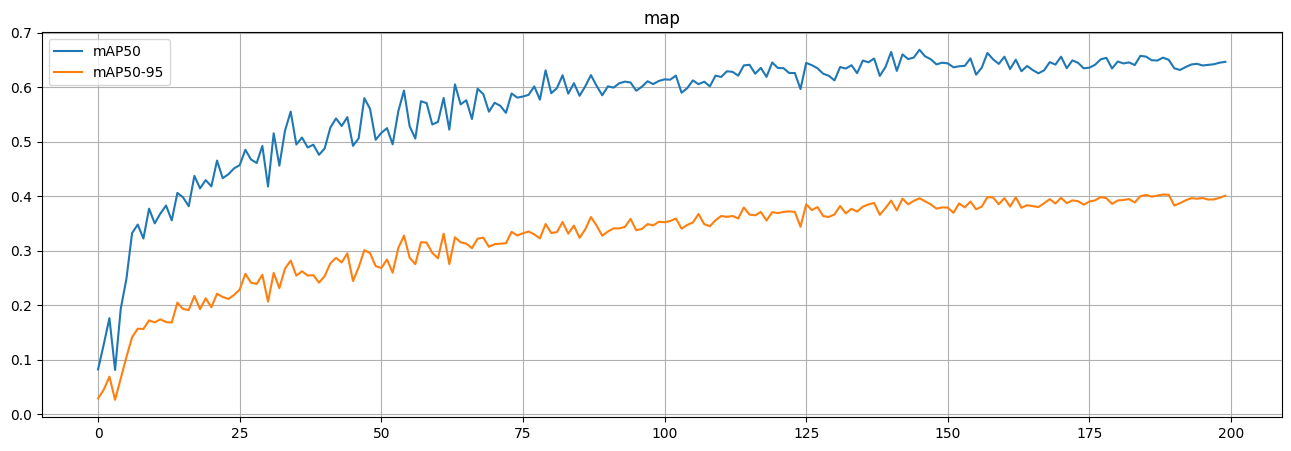

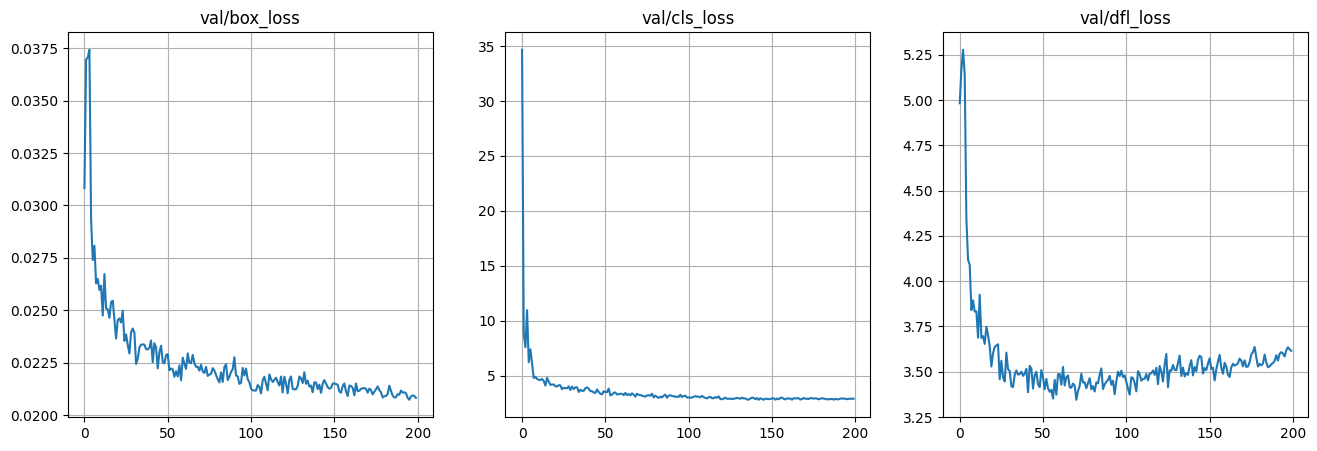

In [10]:
results = pd.read_csv('/kaggle/working/runs/detect/welding_v1_train/results.csv')

plt.figure(figsize=(16, 5))
plt.title('map')

plt.plot(results['metrics/mAP50(B)'], label='mAP50')
plt.plot(results['metrics/mAP50-95(B)'], label='mAP50-95')
plt.legend()
plt.grid()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
loss = ['val/box_loss', 'val/cls_loss', 'val/dfl_loss']
for i in range(3):
    axs[i].plot(results[loss[i]], label=loss[i])
    axs[i].set_title(loss[i])
    axs[i].grid()

Displaying results from model trained on version 1 with augmentation:

image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/good_weld_vid1778_jpeg_jpg.rf.d35cb0ff2061fb1318822c88996de9e0.jpg: 640x640 1 Good Weld, 37.0ms
Speed: 1.5ms preprocess, 37.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


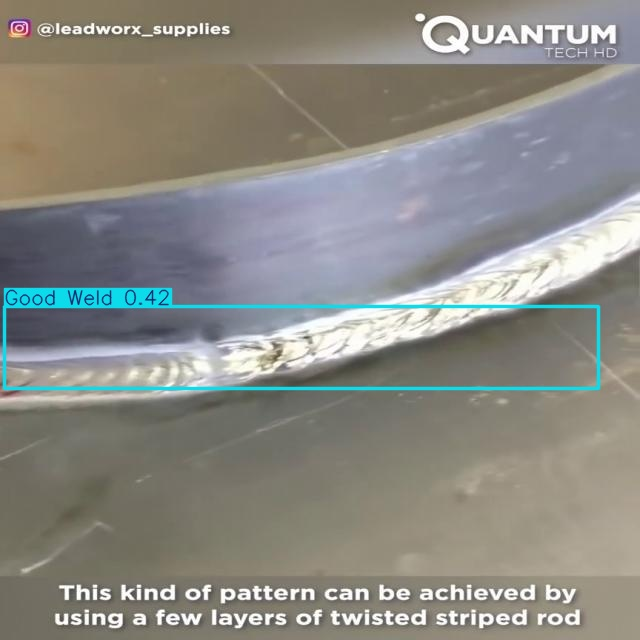


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/good_weld_vid634_jpeg_jpg.rf.9b7bc6b6e69b54eb707c9bab8857b7a1.jpg: 640x640 1 Good Weld, 35.4ms
Speed: 1.4ms preprocess, 35.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


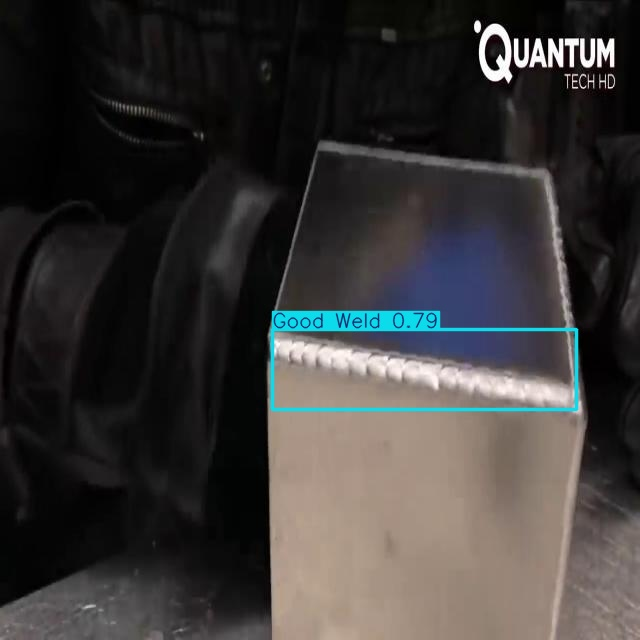


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/good-tig-welds_4_jpeg_jpg.rf.3e3a5bbd002257f6e3845eaecef98355.jpg: 640x640 1 Good Weld, 35.4ms
Speed: 1.3ms preprocess, 35.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


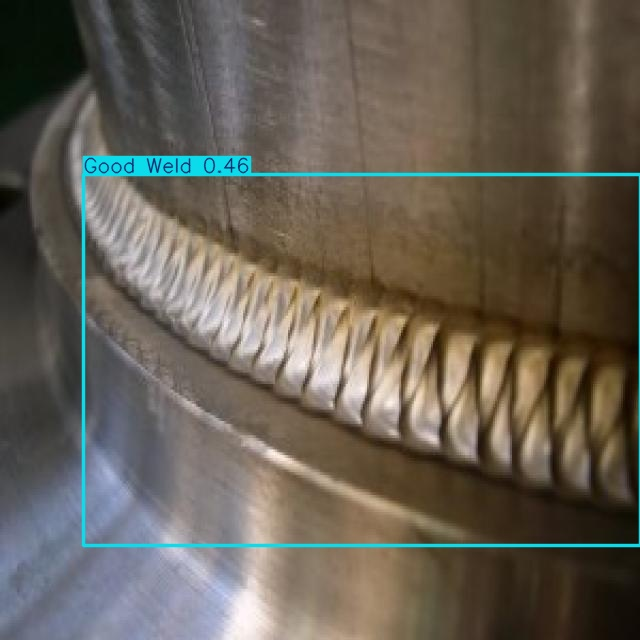


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/Good-Welding-images_23_jpeg_jpg.rf.fdf50352e3c124ff6edab3e96257a040.jpg: 640x640 1 Good Weld, 1 Defect, 35.4ms
Speed: 1.4ms preprocess, 35.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


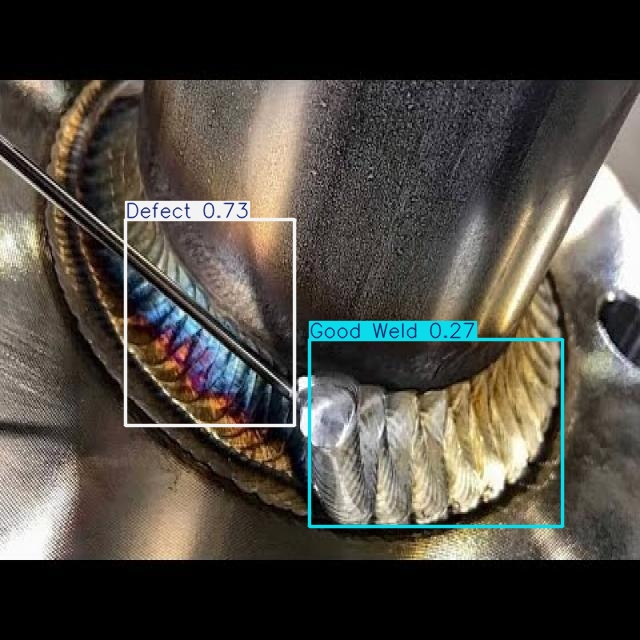


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/SampleV1_1_mp4-42_jpg.rf.6e68d9186e630ffb996233ad2a593f51.jpg: 640x640 2 Bad Welds, 2 Good Welds, 4 Defects, 35.4ms
Speed: 1.9ms preprocess, 35.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


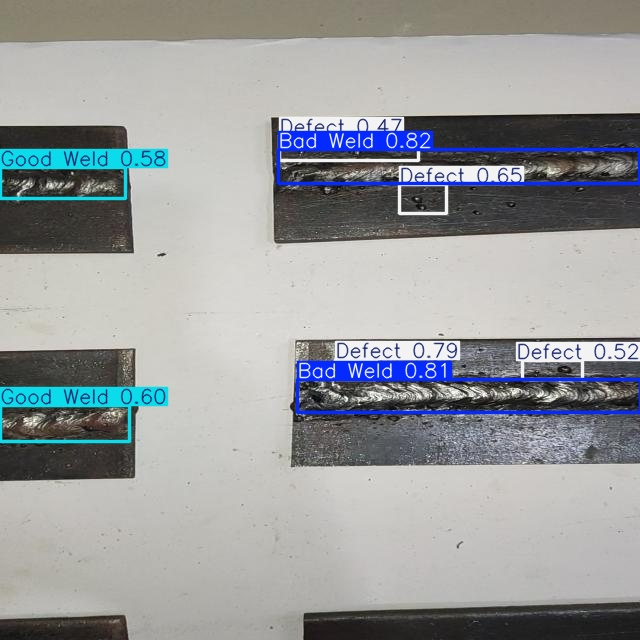

In [11]:
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = images[:num_images]
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(image_path)))
            result_image_path = os.path.join(save_dir, os.path.basename(image_path))
            display(Image.open(result_image_path))
    
print("Displaying results from model trained on version 1 with augmentation:")
display_results(model_v1, os.path.join(v1_dir, 'test/images'))